# Practical - Interest Rates Modeling


**Group composition**:
- Amal BACHA
- Lucas RODRIGUEZ

**Deadline**: Wednesday, November 23 2022

In [18]:
# Importing necessary libraries
import xlrd
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import interp1d
import warnings

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

## Function definitions

In [19]:
def SABR(alpha,beta,rho,nu,F,K,time,MKT): # all variables are scalars
    """
    
    """
    
    if K <= 0:   # negative rates' problem, need to shift the smile
        # Computing SABR volatility and difference with market volatility
        VOL = 0
        diff = 0
        
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (alpha/V)*A
        diff = VOL - MKT
        
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (nu*logFK*A)/(x*B)
        diff = VOL - MKT

    # Writing the output SABR volatility
    print(round(VOL,4))
    outvol.write('%r;' %round(VOL,4))
     
    # Writing the difference between SABR volatility and market volatility
    if MKT == 0:
        diff = 0
        vol_diff.write('%s;' %'No market data')
    else:
        vol_diff.write('%r;' %round(diff,4))

In [20]:
def smile(alpha, beta, rho, nu, F, K, time, MKT, i): # F, time and the parameters are scalars, K and MKT are vectors, i is the index for tenor/expiry label
    """
    
    """
    print(label_ten[i] , '\t' , label_exp[i])
    
    # Writing the labels for tenor and expiry
    outvol.write('%s;%s;' %(label_ten[i],label_exp[i]))
    vol_diff.write('%s;%s;' %(label_ten[i],label_exp[i]))
    parameters.write('%s;%s;' %(label_ten[i],label_exp[i]))
    
    # Computing the SABR volatility for this configuration
    for j in range(len(K)):
        if K[0] <= 0:
            shift(F,K)
        SABR(alpha,beta,rho,nu,F,K[j],time,MKT[j])

    print()
    # Writing the difference between SABR volatility and market volatility
    outvol.write('\n')
    vol_diff.write('\n')
    
    # Writing the parameter values
    parameters.write('%f;%f;%f;%f;' %(alpha ,beta ,rho ,nu))
    parameters.write('\n')

In [21]:
def SABR_vol_matrix(alpha,beta,rho,nu,F,K,time,MKT): # F, time and the parameters are vectors, K and MKT are matrices
    """
    
    """
    print()
    #print((2+((num_strikes-1)/2))*'       '+'SABR VOLATILITIES')
    print('  ' , '\t' , 'strikes:')
    for i in range(num_strikes):
        print(label_strikes[i])
    print()
    
    # Writing necessary headers
    #outvol.write('%s;' %'SABR VOLATILITIES')
    #outvol.write('\n')
    #vol_diff.write('%s;' %'VOLATILITY DIFFERENCES')
    #vol_diff.write('\n')
    #parameters.write('%s;' %'PARAMETERS')
    #parameters.write('\n')
    outvol.write('%s;%s;' %(' ','strikes:'))
    vol_diff.write('%s;%s;' %(' ','strikes:'))
    
    # Writing labels
    for j in range(len(strike_spreads)):
        outvol.write('%s;' %label_strikes[j])
        vol_diff.write('%s;' %label_strikes[j])
    
    # Writing necessary headers
    outvol.write('\n')
    vol_diff.write('\n')
    print('tenor' , '\t' ,   'expiry')
    
    # Writing the parameter values
    parameters.write('%s;%s;%s;%s;%s;%s' %('tenor','expiry','alpha','beta','rho','nu'))
    parameters.write('\n')
    
    # Compting the smiles
    for i in range(len(F)):
        smile(alpha[i],beta[i],rho[i],nu[i],F[i],K[i],time[i],MKT[i],i)

In [22]:
def shift(F,K):
    """
    
    """
    shift = 0.001 - K[0]
    for j in range(len(K)):
        # Translating the swaption's strike K and the forward rate F
        K[j] = K[j] + shift
        F = F + shift   

In [23]:
def objfunc(par,F,K,time,MKT):
    """
    
    """
    sum_sq_diff = 0
    
    if K[0]<=0:
        shift(F,K)
    
    for j in range(len(K)):
        if MKT[j] == 0:   
            diff = 0       
    
        elif F == K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)

            # Computing SABR volatility and difference with market volatility
            VOL = (par[0]/V)*A
            diff = VOL - MKT[j]
        
        elif F != K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            z = (par[3]/par[0])*V*logFK
            x = math.log( ( math.sqrt(1-2*par[2]*z+z**2) + z - par[2] ) / (1-par[2]) )
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)
            
            # Computing SABR volatility and difference with market volatility
            VOL = (par[3]*logFK*A)/(x*B)
            diff = VOL - MKT[j]  
        
        sum_sq_diff = sum_sq_diff + diff**2  
        obj = math.sqrt(sum_sq_diff)
    return obj

The above function will be considered to calibrate the SABR model:

In [100]:
def calibration(starting_par,F,K,time,MKT):
    """
    """
    for i in range(len(F)):
        x0 = starting_par
        bnds = ( (0.001,None) , (0,1) , (-0.999,0.999) , (0.001,None)  )
        res = minimize(objfunc, # for a constrained minimization of multivariate scalar functions
                       x0 , 
                       (F[i],K[i],time[i],MKT[i]),
                       bounds = bnds, 
                       method="SLSQP")
        alpha[i] = res.x[0]
        beta[i] = res.x[1]
        rho[i] = res.x[2]
        nu[i] = res.x[3]

We will then, in a second time, use the next values in order to study the impact of the SABR parameters $\alpha$, $\beta$, $\rho$ and $\mu$:


$\longrightarrow$ In order to study the impact of a given parameter, we fix the three other ones to a constant value (we have chosen the value of $\frac{1}{2}$).

In [110]:
# Values to be evaluated
ALPHA = [0.15, 0.2, 0.25]
BETA = [0, 0.5, 1]
RHO = [-0.92, 0, 0.92]
NU = [0.01, 0.75, 1.5]

In [111]:
def calibration(F):
    alpha = [ALPHA[0]]*len(F)
    beta = [1]*len(F)
    rho = [-0.6]*len(F)
    nu = [1.2]*len(F)

## I/O (Inputs & Outputs) handling

In [122]:
# Opening the FDs for each file
SUFFIX = "alpha_3"
outvol = open(f'outvol_{SUFFIX}.csv', 'w')             # file output of volatilities
vol_diff = open(f'vol_diff_{SUFFIX}.csv', 'w')  # file output differences between SABR and Market volatilities
parameters = open(f'parameters_{SUFFIX}.csv', 'w')     # file output parameters

# Loading input file = market data
INPUTFILE_NAME = "market_data.xlsx"
SHEET_NAME = "Swaptions data"
while True:
    try:
        #file_input = pd.read_excel(io=INPUTFILE_NAME, sheet_name=SHEET_NAME, header=True)
        file_input = xlrd.open_workbook("MAIN.xls")     # load market data
    except Exception as e:
        print(f'Input file is not in the directory! : {e}')
    break
    
# Switching to the given sheet
Market_data = file_input.sheet_by_name('Swaptions data')        # file input forward rates

## Setting swaptions characteristics

In [123]:
strike_spreads = []
j = 0

while True:
    try:
        strike_spreads.append(int(Market_data.cell(1,3+j).value))
        j = j+1
    except:
        break
num_strikes = len(strike_spreads)

expiries=[]
i=0
while True:
        try:
            expiries.append(Market_data.cell(2+i,1).value)
            i = i + 1
        except:
            break

tenors=[]
i=0
while True:
    try:
        tenors.append(Market_data.cell(2+i,0).value)
        i = i + 1
    except:
        break


# to create the ATM forward rates
F = []
i=0
while True:
    try:
        F.append(Market_data.cell(2+i,2).value)
        i = i+1
    except:
        break

# to create the strike grid
K = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        K[i][j] = F[i] + 0.0001*(strike_spreads[j])  

# to create market volatilities            
MKT = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        MKT[i][j] = Market_data.cell(2+i,3+j).value


# set starting parameters
starting_guess = numpy.array([0.001,0.5,0,0.001]) # x_0
alpha = len(F)*[starting_guess[0]]
beta = len(F)*[starting_guess[1]]
rho = len(F)*[starting_guess[2]]
nu = len(F)*[starting_guess[3]]

## Setting labels

In [124]:
exp_dates = len(expiries)*[0]
for i in range(len(expiries)):
    if expiries[i] < 1:
        exp_dates[i] = str(int(round(12*expiries[i])))+'m'
    else:
        exp_dates[i] = str(int(round(expiries[i])))+'y'
        if expiries[i]-round(expiries[i]) > 0:
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
        elif expiries[i]-round(expiries[i]) < 0:
            exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

ten_dates = len(tenors)*[0]
for i in range(len(tenors)):
    if tenors[i] < 1:
        ten_dates[i] = str(int(round(12*tenors[i])))+'m'
    else:
        ten_dates[i] = str(int(round(tenors[i])))+'y'
        if tenors[i]-round(tenors[i]) > 0:
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
        elif tenors[i]-round(tenors[i]) < 0:
            ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

label_exp = exp_dates
label_ten = ten_dates
label_strikes = num_strikes*[0]
for i in range(num_strikes):
    if strike_spreads[i] == 0 :
        label_strikes[i] = 'ATM'
    else:
        label_strikes[i] = str(strike_spreads[i])

## Functions call

In [125]:
#calibration(starting_guess,F,K,expiries,MKT)
#calibration(F)
alpha = [ALPHA[2]]*len(F)
beta = [1]*len(F)
rho = [-0.6]*len(F)
nu = [1.2]*len(F)
SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)


   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
1.055
0.4809
0.243
0.2146
0.2437
0.2784
0.3104
0.3644
0.4084

2y 	 6m
1.0666
0.4935
0.2546
0.2135
0.2376
0.2715
0.3033
0.3576
0.4018

2y 	 9m
1.0821
0.5111
0.2723
0.2151
0.2292
0.2613
0.2929
0.3472
0.3917

2y 	 1y
1.0992
0.5306
0.293
0.2226
0.2215
0.2502
0.2811
0.3354
0.3802

2y 	 2y
1.1407
0.6258
0.4057
0.3229
0.2551
0.2186
0.2233
0.2682
0.3126

2y 	 5y
0.5673
0.4441
0.3437
0.3002
0.2628
0.2356
0.2237
0.2353
0.262

2y 	 10y
0.5288
0.4298
0.3452
0.308
0.2755
0.2506
0.2367
0.2396
0.2607

5y 	 3m
1.1632
0.6211
0.4006
0.3181
0.2506
0.2146
0.2198
0.2645
0.3085

5y 	 6m
1.0158
0.5969
0.3933
0.3154
0.2513
0.2158
0.2188
0.2608
0.3034

5y 	 9m
0.9151
0.5737
0.386
0.3126
0.2519
0.2171
0.2179
0.2569
0.2982

5y 	 1y
0.8407
0.5525
0.3791
0.31
0.2526
0.2185
0.2173
0.2532
0.293

5y 	 2y
0.6768
0.4923
0.3583
0.3024
0.2551
0.224
0.2169
0.242
0.2761

5y 	 5y
0.5393
0.4292
0.3374
0.2974
0.2628
0.237
0.2244
0.2322
0.2562

5y 	 10y

## Close output files procedure

In [126]:
outvol.close()
vol_diff.close()
parameters.close()

## Data processing

In [68]:
outvol = pd.read_csv("outvol.csv", sep=";")
vol_diff = pd.read_csv("vol_diff.csv", sep=";")
parameters = pd.read_csv("parameters.csv", sep=";", index_col=False)
parameters.set_index(["tenor", "expiry"], inplace=True)

In [69]:
parameters.head()

alpha      beta       rho        nu
tenor expiry                                        
2y    3m      0.005869  0.000000 -0.617531  1.429847
      6m      0.005796  0.000000 -0.441789  1.172068
      9m      0.005580  0.000000 -0.182401  0.899446
      1y      0.006693  0.051822  0.160915  0.805916
      2y      0.006057  0.000000  0.009776  0.997564

In [70]:
INDEX = list(parameters.index)
INDEX_LABELS = [k[0] + " - " + k[1] for k in INDEX]
INDEX_RANGE = list(range(len(parameters)))

### Graphs of the evolutions of $\alpha$, $\beta$ and $\rho$ with respect to tenor/expiry

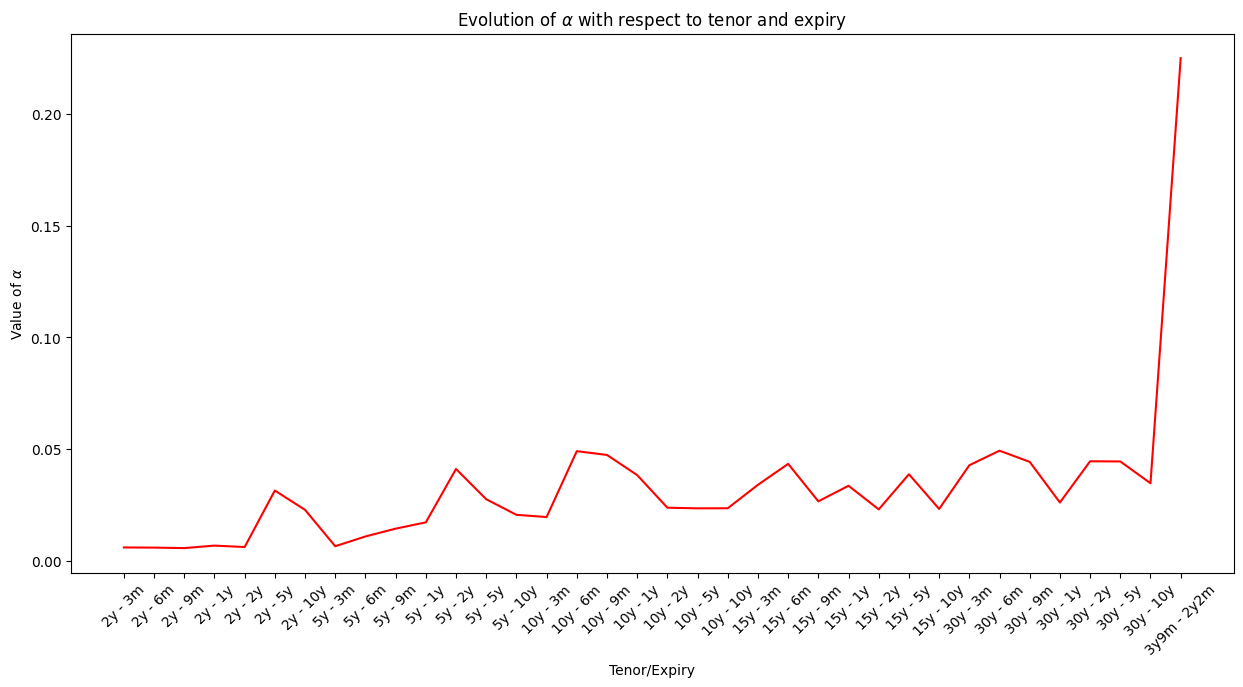

In [71]:
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="red", rot=45)
_ = plt.title(r"Evolution of $\alpha$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\alpha$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

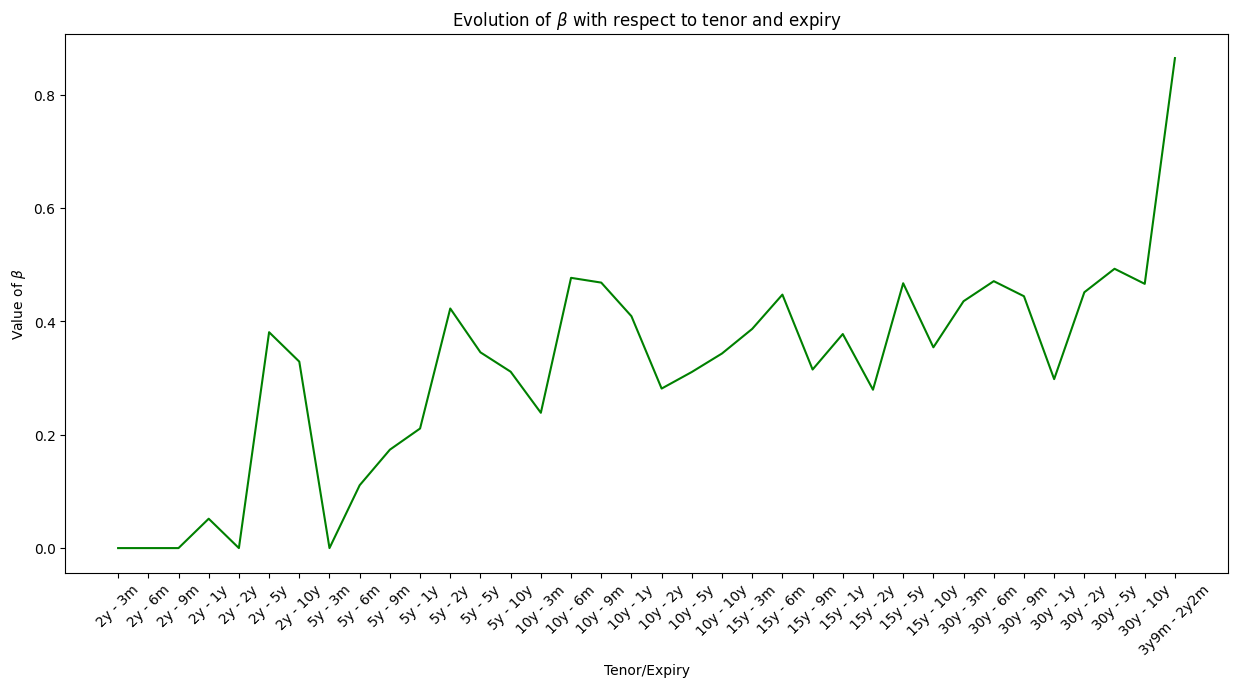

In [72]:
plt.figure(figsize=(15, 7))
_ = parameters["beta"].plot(color="green", rot = 45)
_ = plt.title(r"Evolution of $\beta$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\beta$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

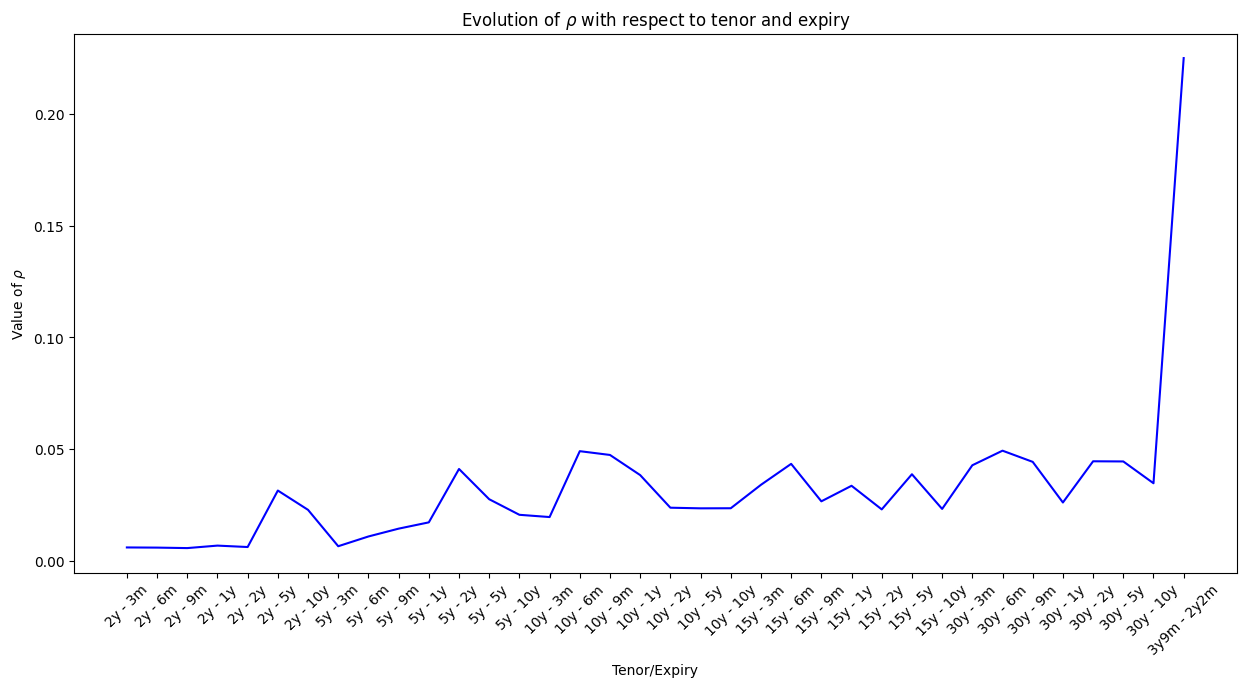

In [73]:
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="blue", rot = 45)
_ = plt.title(r"Evolution of $\rho$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\rho$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

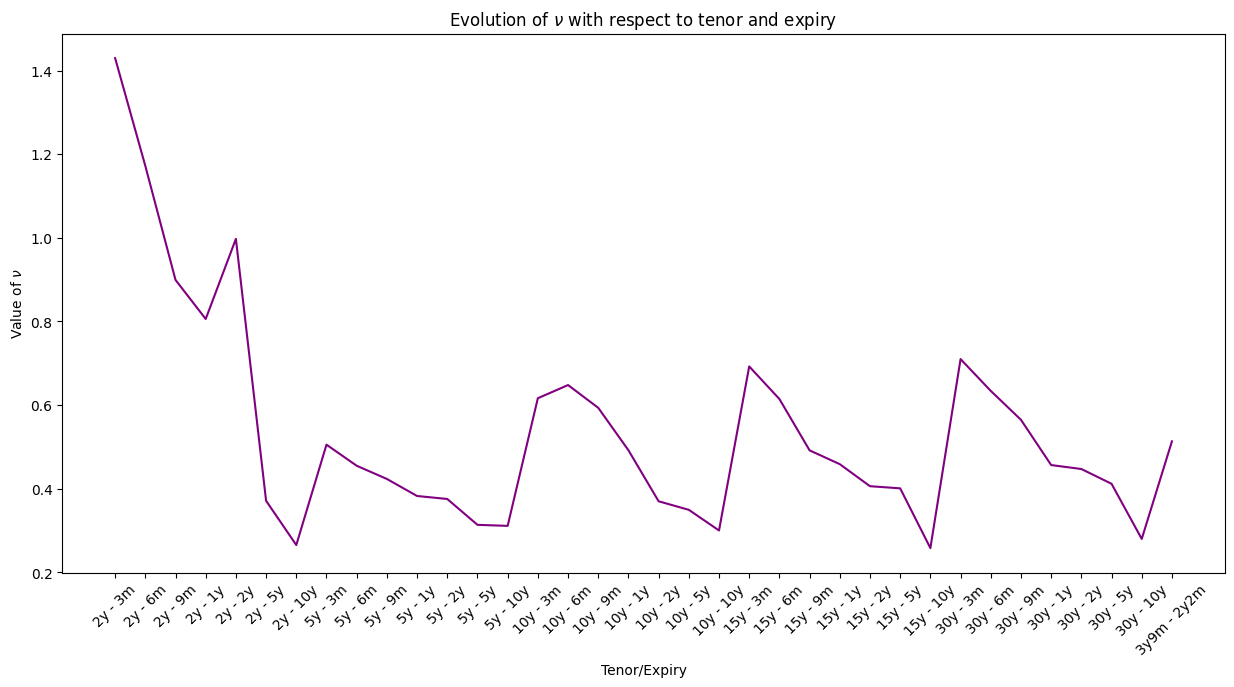

In [74]:
plt.figure(figsize=(15, 7))
_ = parameters["nu"].plot(color="purple", rot = 45)
_ = plt.title(r"Evolution of $\nu$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\nu$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

### Graphs of the volatility with respect to different strikes

In [75]:
# Importing the volatilities from SABR model simulations (input data) and market data (output data)
VOL_SABR = pd.read_csv("outvol.csv", 
                       sep=";", 
                       header=0)
VOL_MKT = pd.read_excel('market_data.xlsx', 
                        header=1)

PARAMETERS = pd.read_csv("parameters.csv", 
                         sep=";", 
                         index_col=False)

# Strike spreads
STRIKES_SPREADS = [-150, -100, -50, -25, 0, 25, 50, 100, 150]

# Index increments
INCREMENTS = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

# Column indices for strikes
STRIKES_COLUMNS_RANGE_SABR = [2, 3, 4, 5, 6, 7, 8, 9, 10] # ATM = 6
STRIKES_COLUMNS_RANGE_MKT = [3, 4, 5, 6, 7, 8, 9, 10, 11] # ATM = 7

# Column index for ATM
ATM_SABR = 6
ATM_MKT = 7

First of all, we want to plot the SABR and market (MKT) volatilities over the consider time period of the given swaption.  

$\longrightarrow$ We are taking the example of the ATM case for each situation.

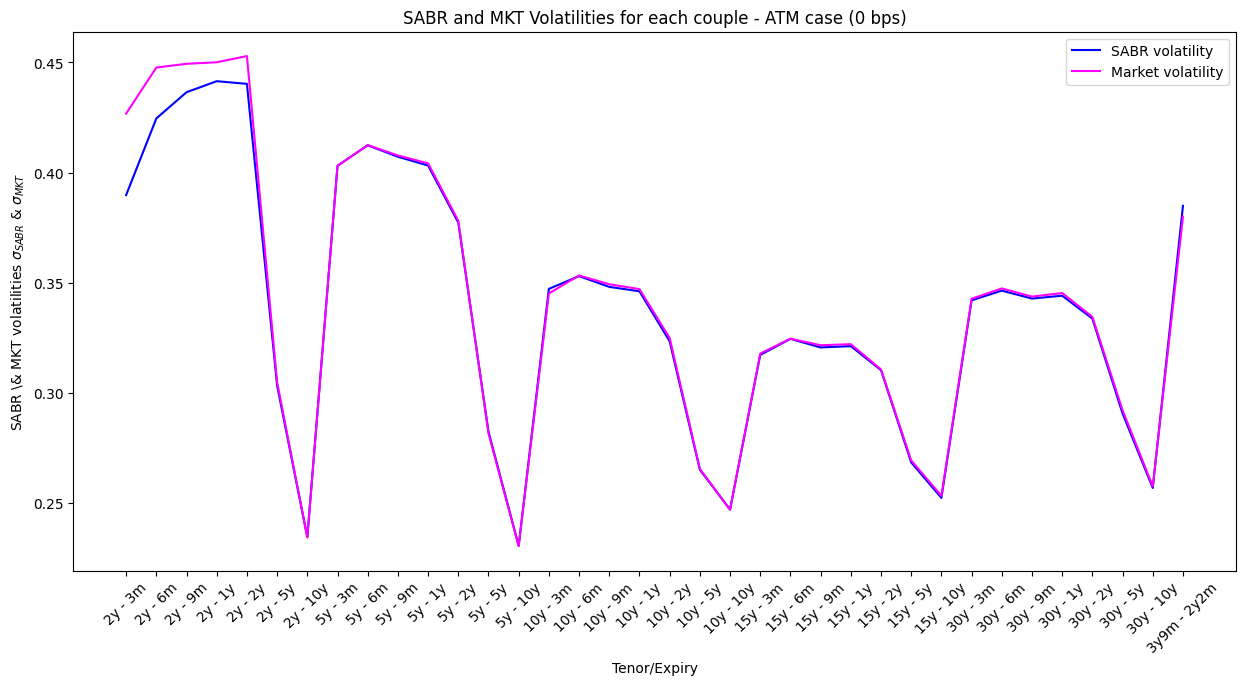

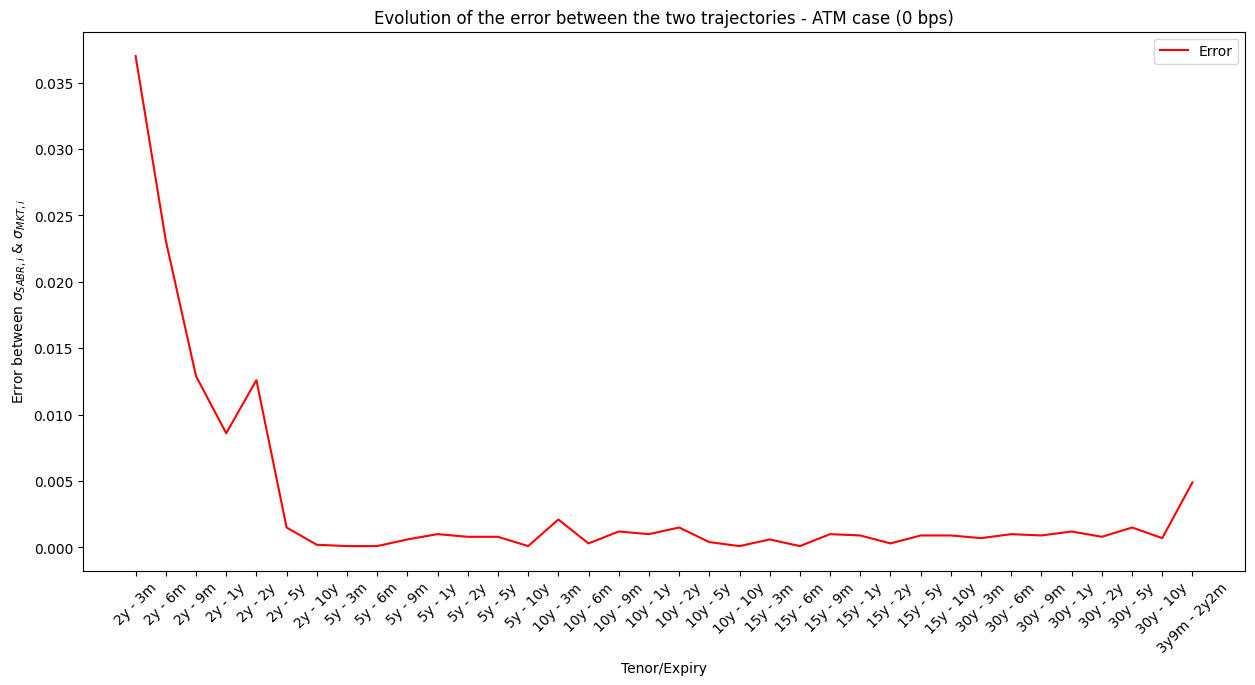

In [77]:
# Plotting the SABR & market volatilities (ATM)
plt.figure(figsize=(15, 7))
_ = VOL_SABR.iloc[:, ATM_SABR].plot(color="blue", rot = 45, label="SABR volatility")
_ = VOL_MKT.iloc[:, ATM_MKT].plot(color="magenta", rot = 45, label="Market volatility")
_ = plt.title(r"SABR and MKT Volatilities for each couple - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"SABR \& MKT volatilities $\sigma_{SABR}$ & $\sigma_{MKT}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

# Computing the absolute error between the two trajectories at ATM
ABSOLUTE_ERROR = abs(VOL_SABR.iloc[:, ATM_SABR] - VOL_MKT.iloc[:, ATM_MKT])

# Plotting the error (ATM)
plt.figure(figsize=(15, 7))
_ = ABSOLUTE_ERROR.plot(color="red", rot = 45, label="Error")
_ = plt.title(r"Evolution of the error between the two trajectories - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Error between $\sigma_{SABR, i}$ & $\sigma_{MKT, i}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

For the other **bps** values of the strike spreads, 

$$(-150, -100, -50, -25, 0, +25, +50, +100, +150)$$

We will perform the same plotting procedure.

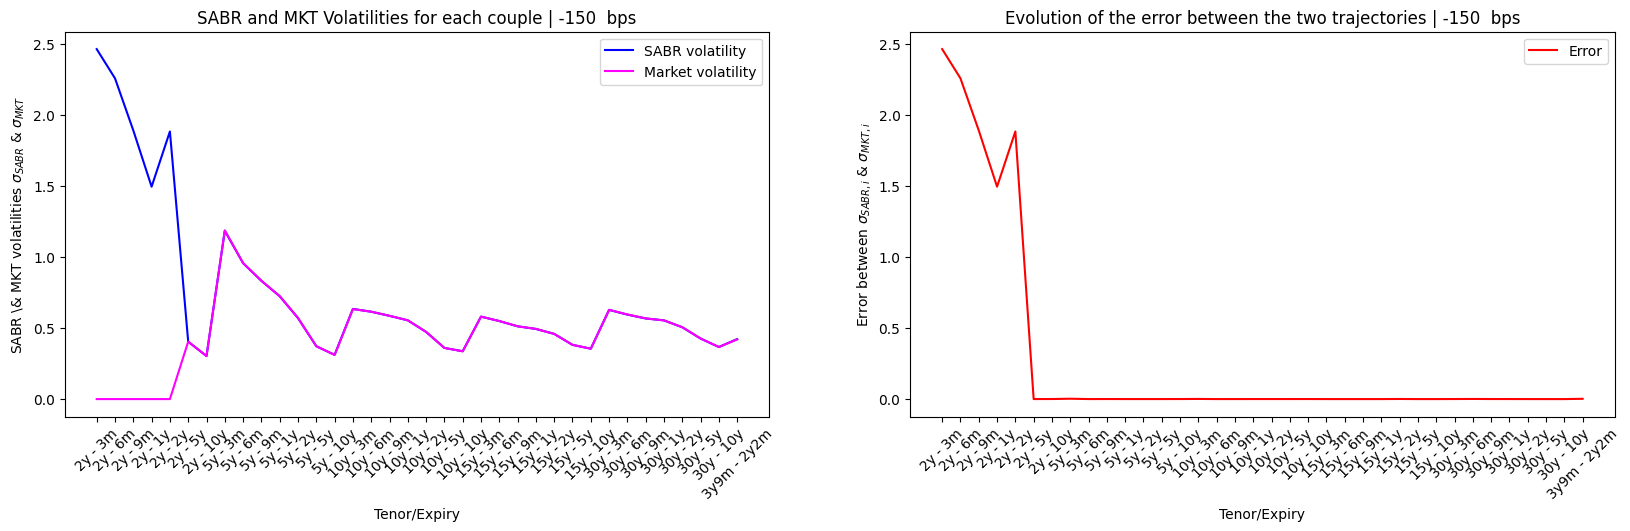

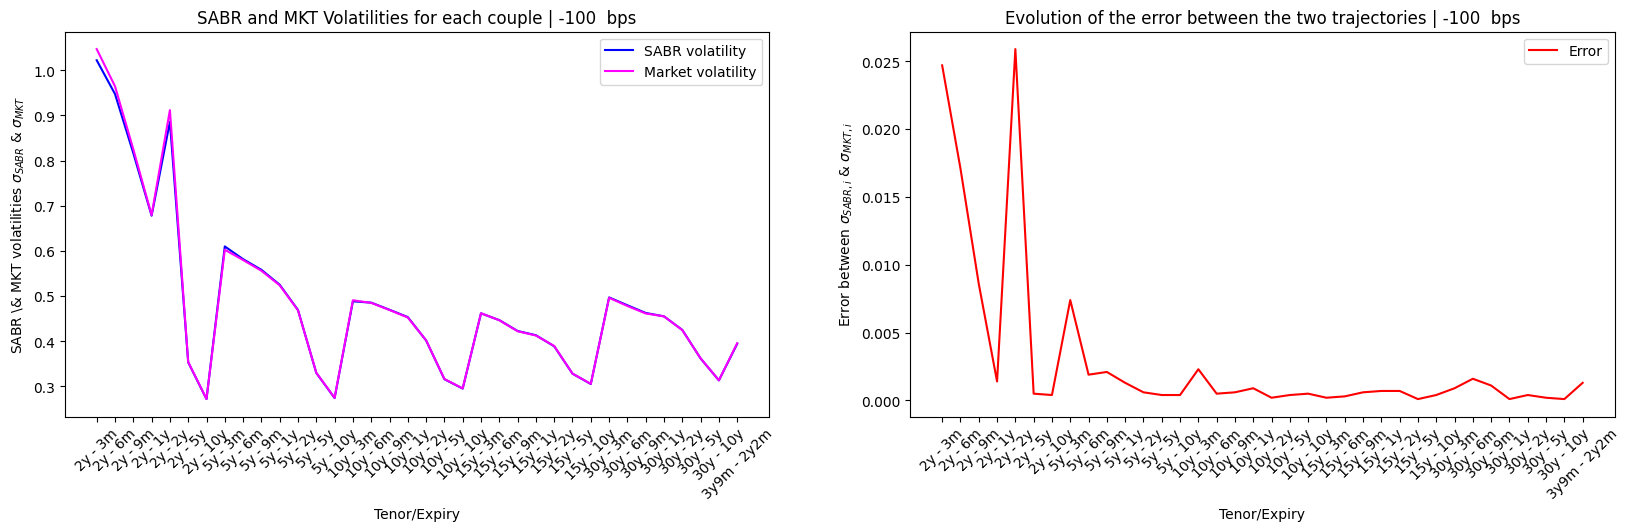

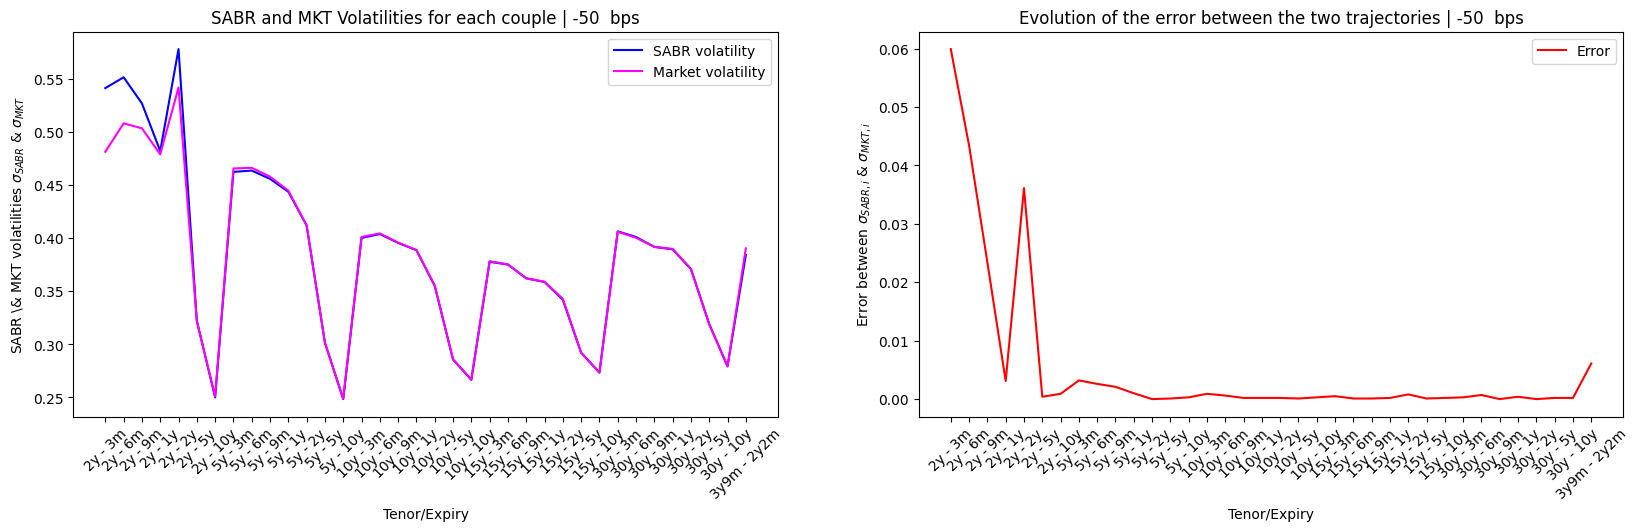

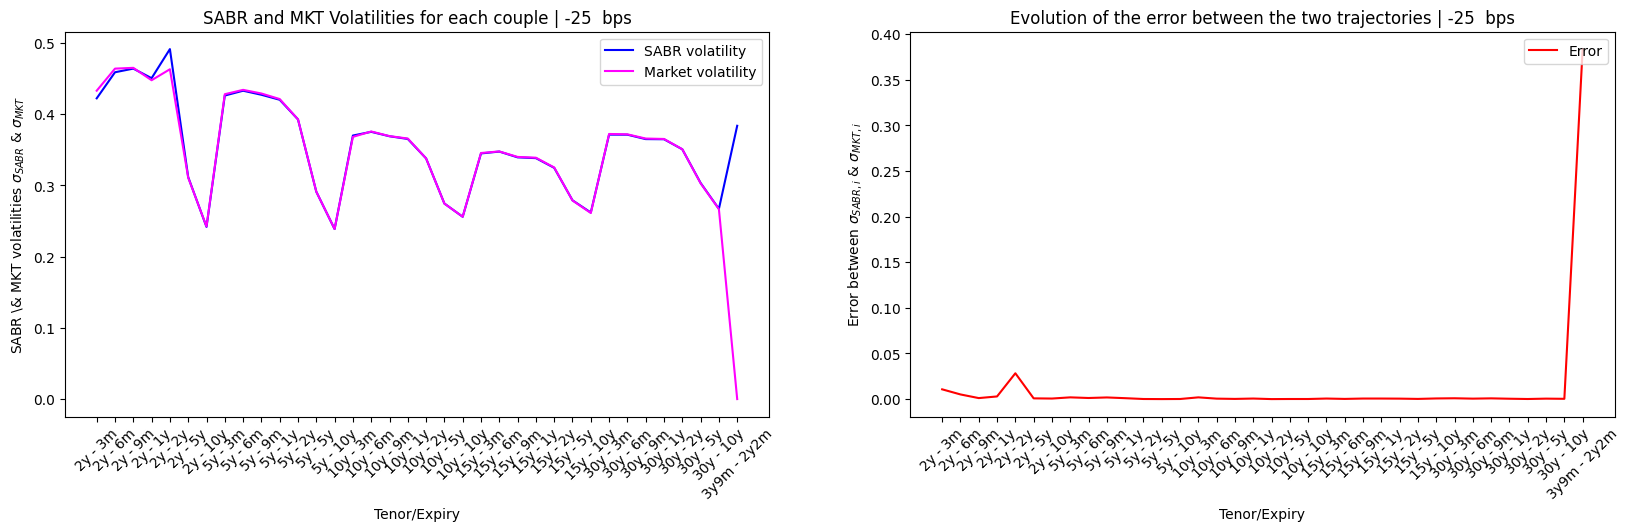

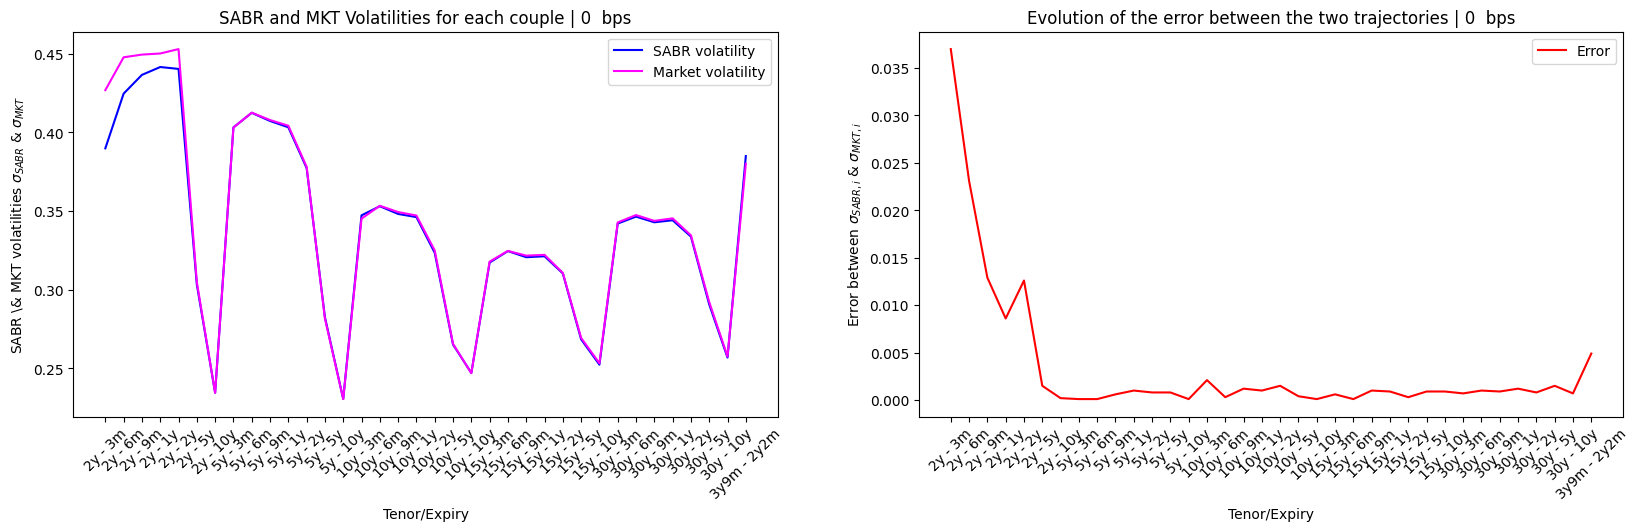

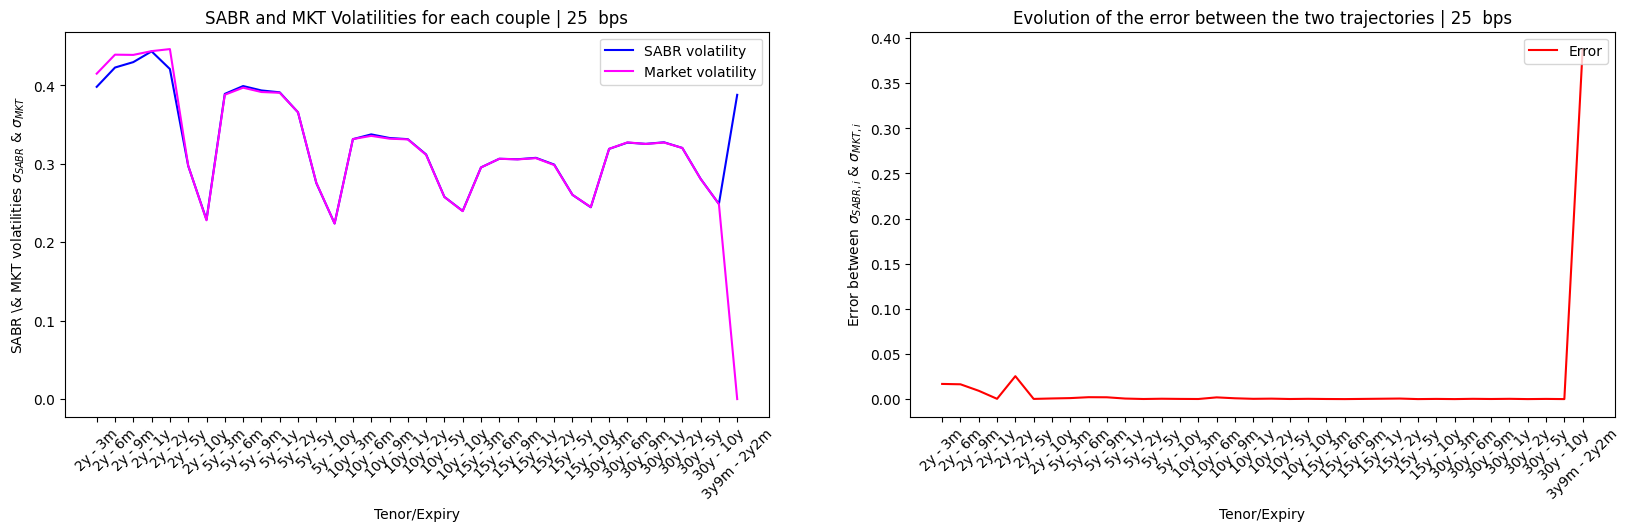

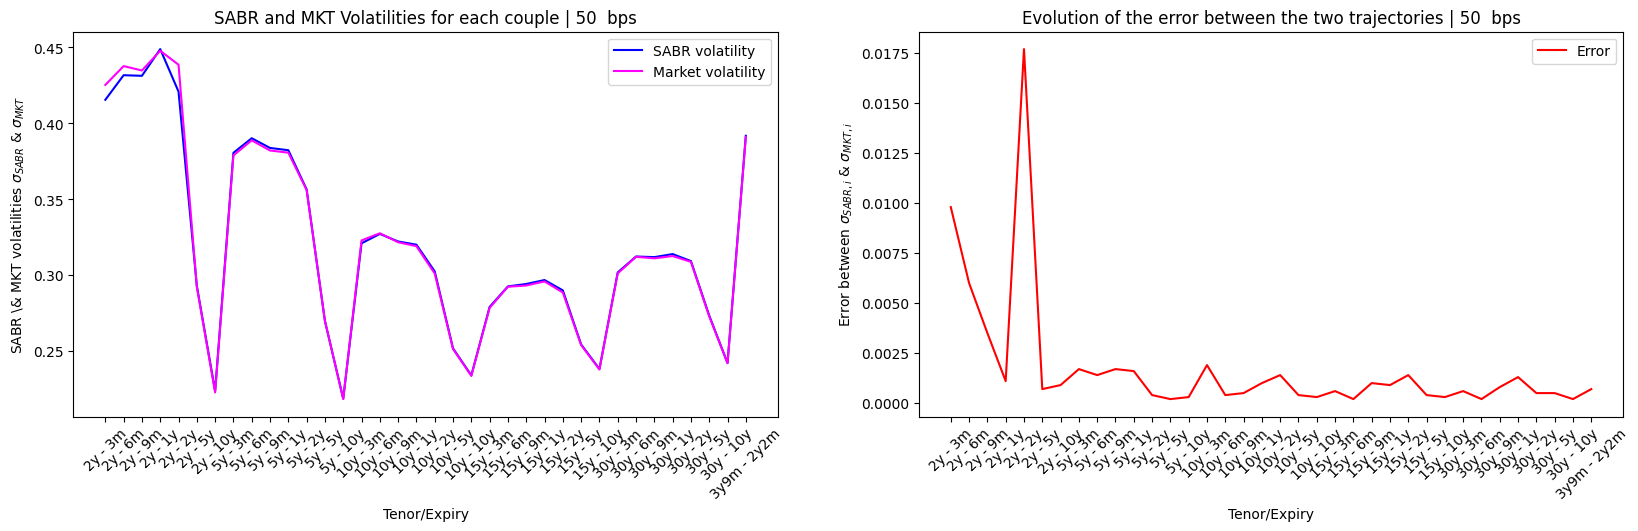

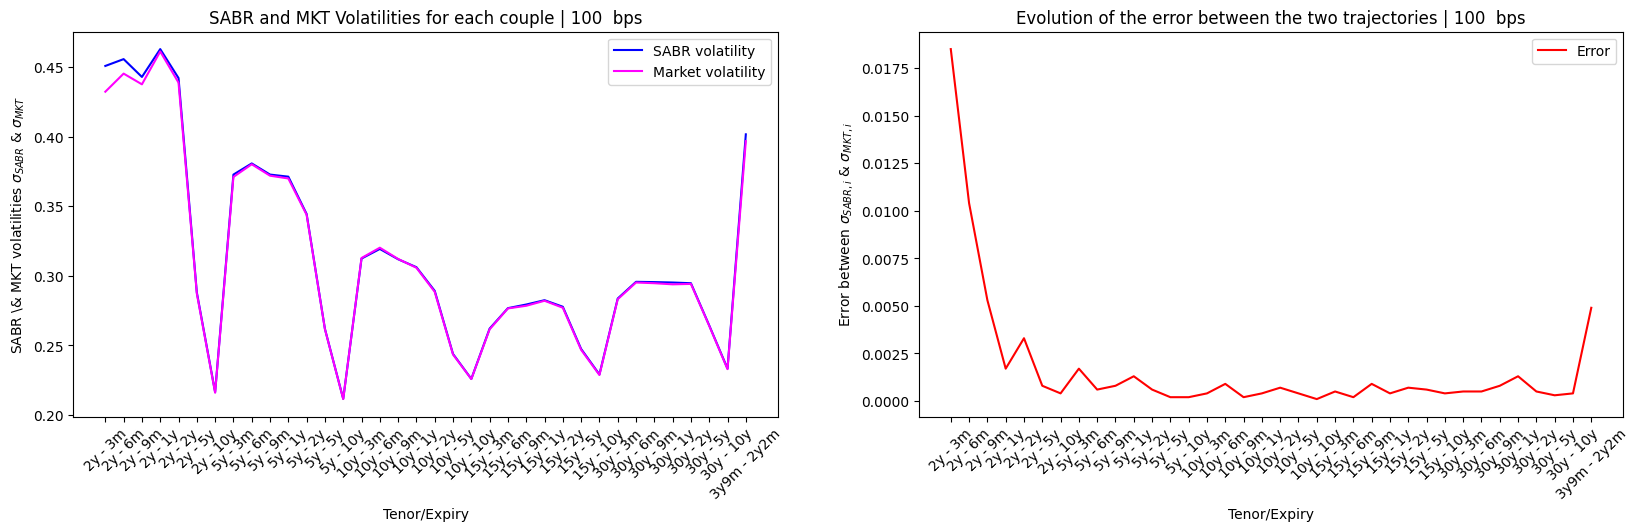

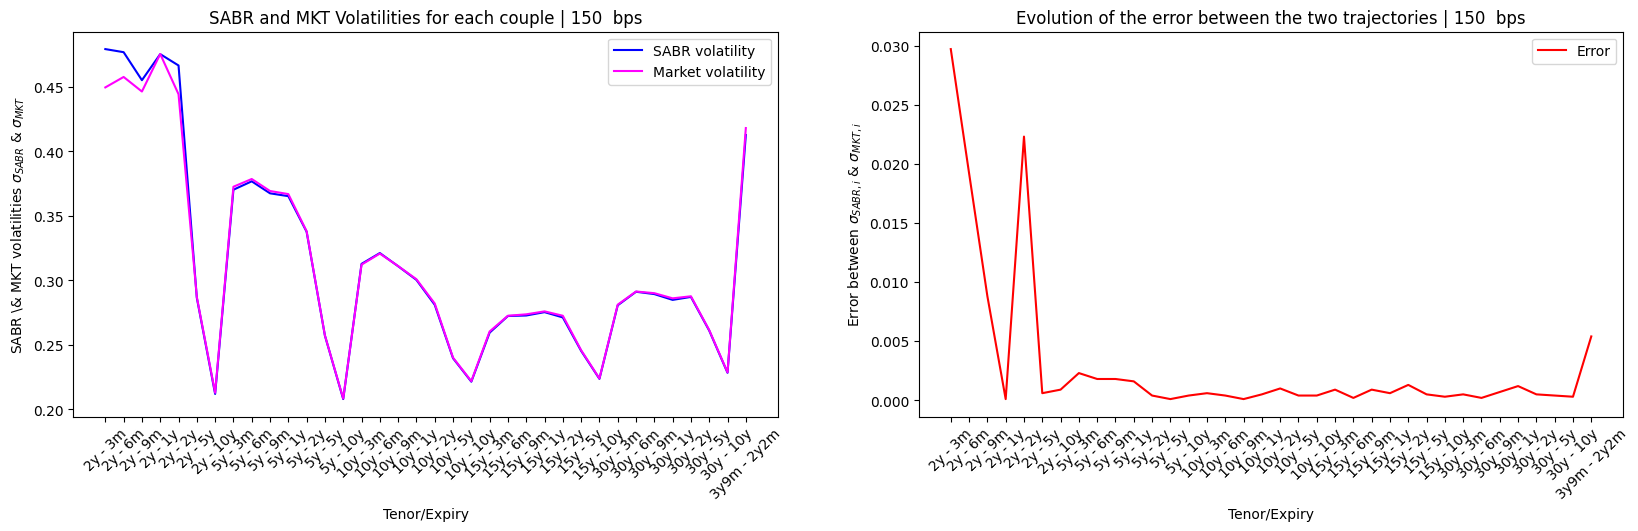

In [78]:
for inc in INCREMENTS:
    # Plotting the SABR & market volatilities
    bps = STRIKES_SPREADS[4 + inc]
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    _ = VOL_SABR.iloc[:, ATM_SABR + inc].plot(color="blue", rot = 45, label="SABR volatility")
    _ = VOL_MKT.iloc[:, ATM_MKT + inc].plot(color="magenta", rot = 45, label="Market volatility")
    _ = plt.title(f"SABR and MKT Volatilities for each couple | {bps}  bps")
    _ = plt.xlabel("Tenor/Expiry")
    _ = plt.ylabel(r"SABR \& MKT volatilities $\sigma_{SABR}$ & $\sigma_{MKT}$")
    _ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
    _ = plt.legend(loc="upper right")

    # Computing the absolute error between the two trajectories
    ABSOLUTE_ERROR = abs(VOL_SABR.iloc[:, ATM_SABR + inc] - VOL_MKT.iloc[:, ATM_MKT + inc])

    # Plotting the error
    plt.subplot(1, 2, 2)
    _ = ABSOLUTE_ERROR.plot(color="red", rot = 45, label="Error")
    _ = plt.title(f"Evolution of the error between the two trajectories | {bps}  bps")
    _ = plt.xlabel("Tenor/Expiry")
    _ = plt.ylabel(r"Error between $\sigma_{SABR, i}$ & $\sigma_{MKT, i}$")
    _ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
    _ = plt.legend(loc="upper right")

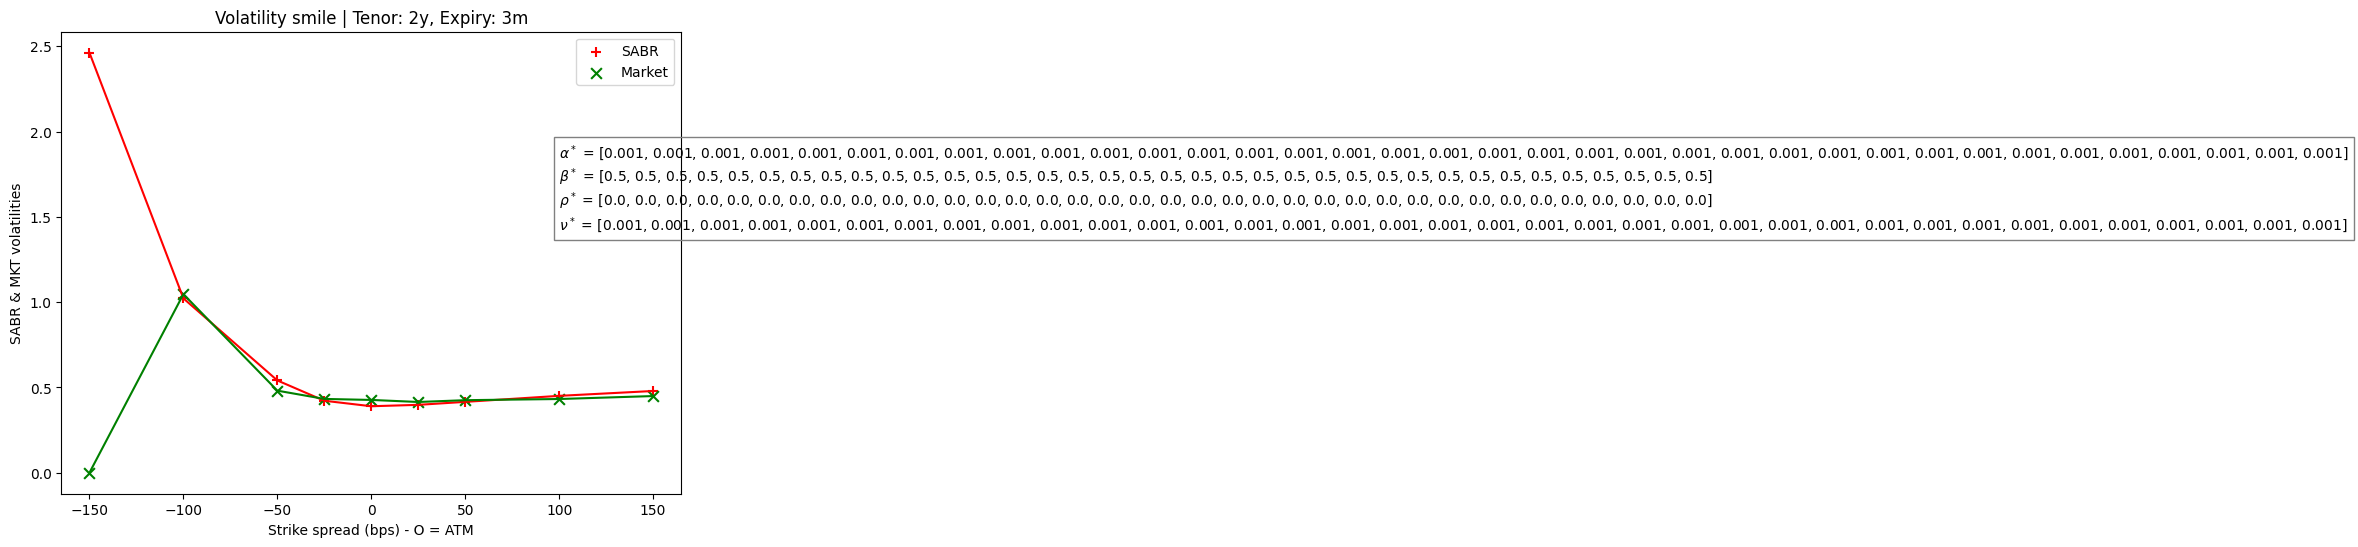

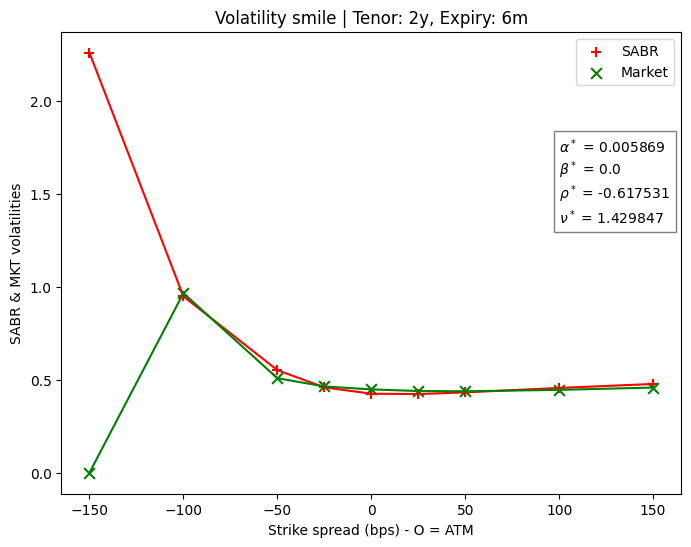

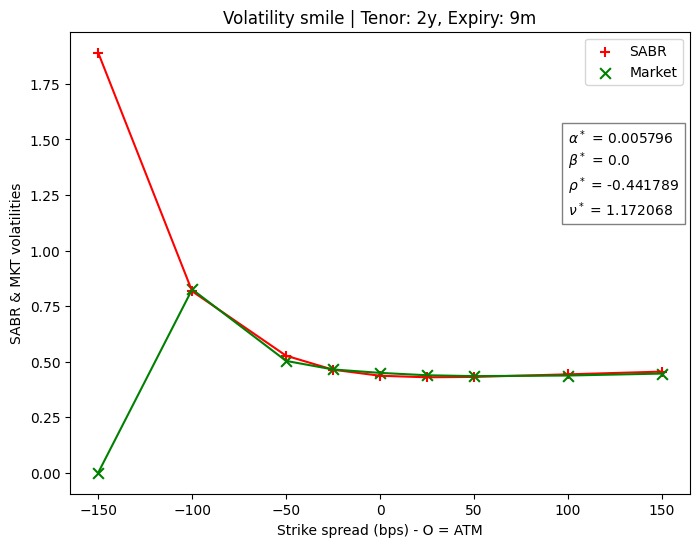

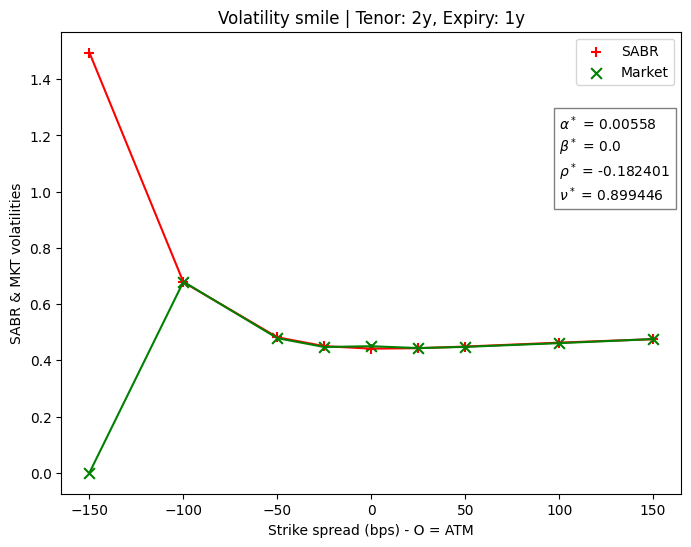

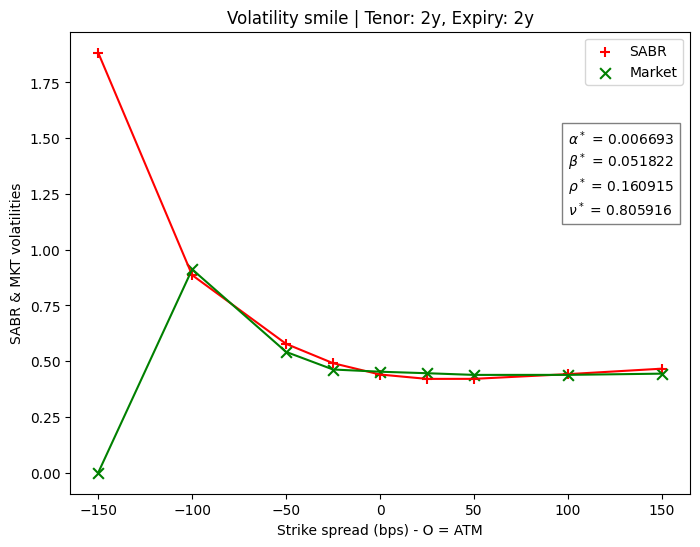

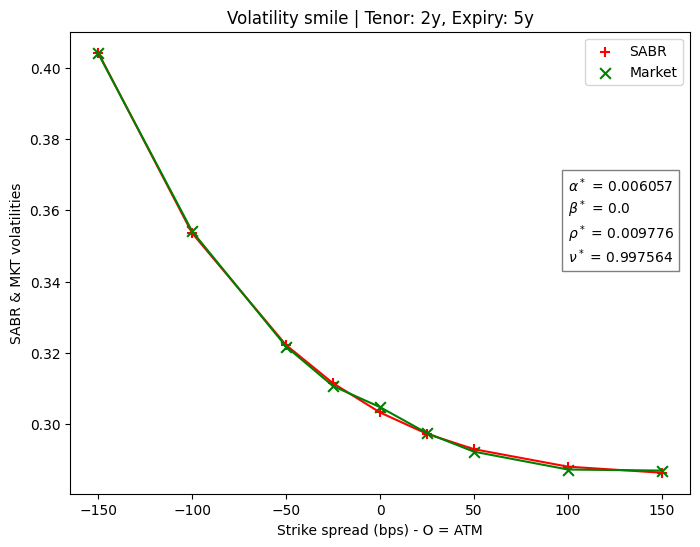

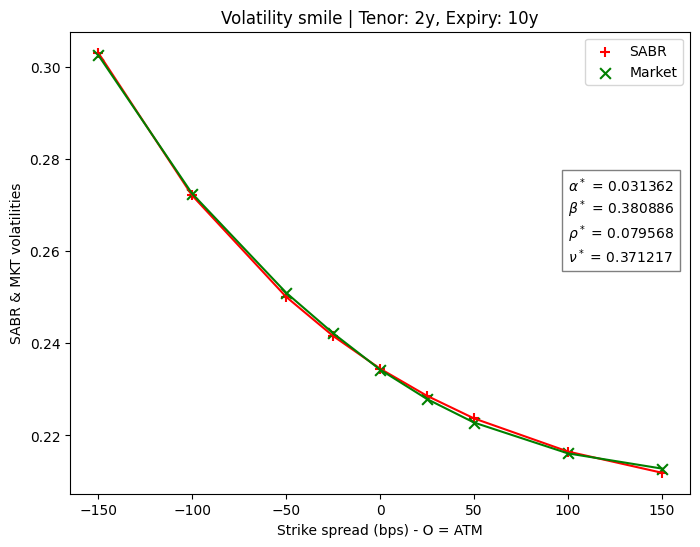

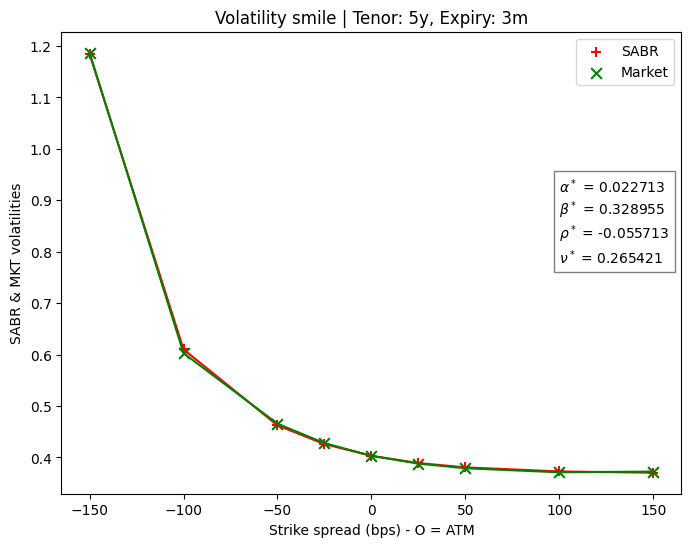

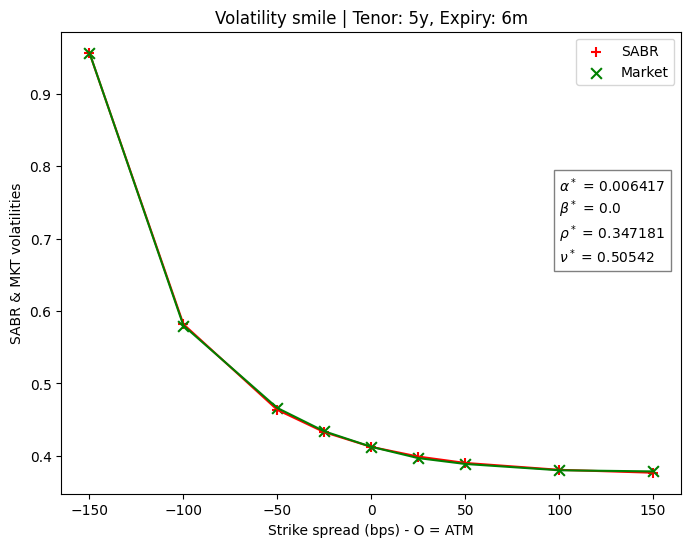

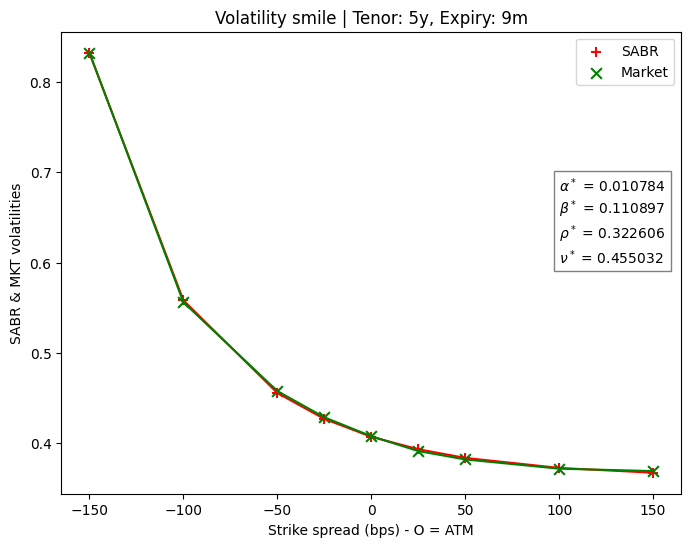

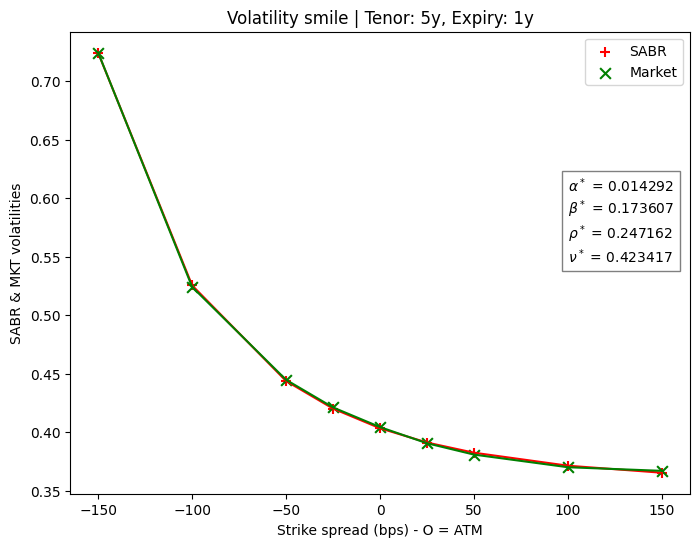

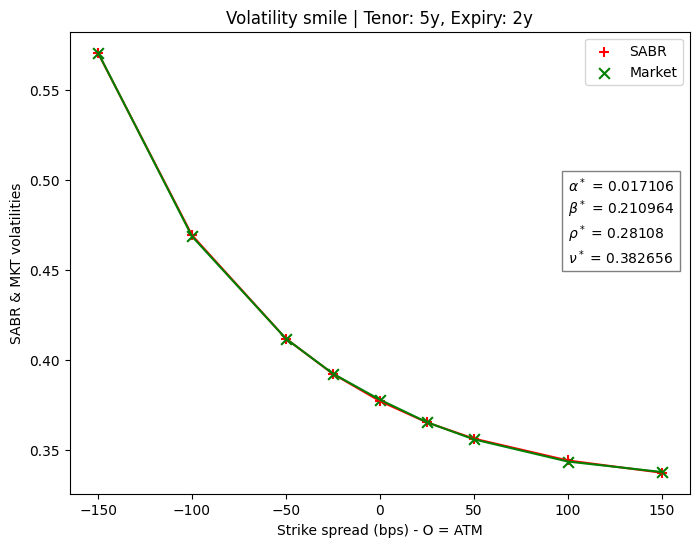

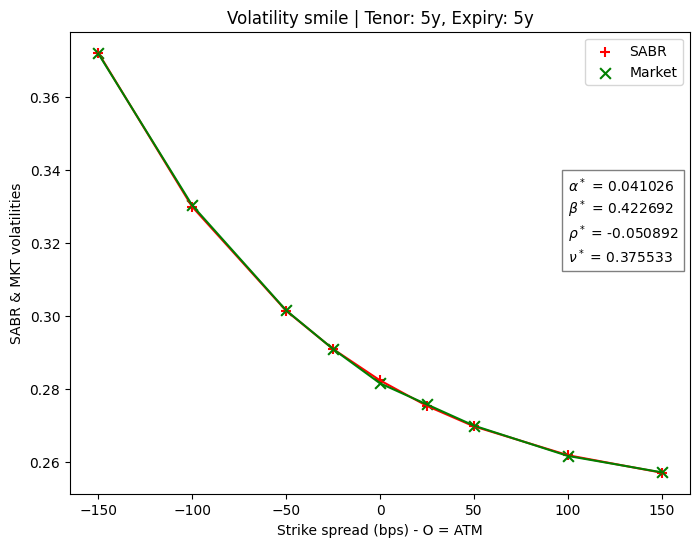

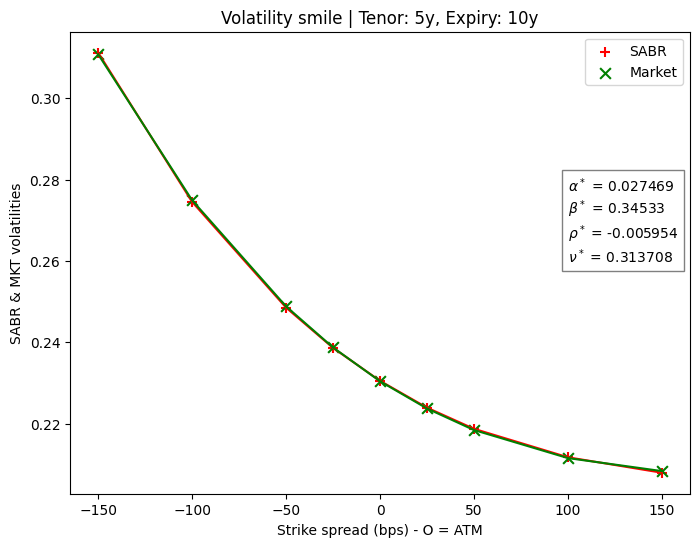

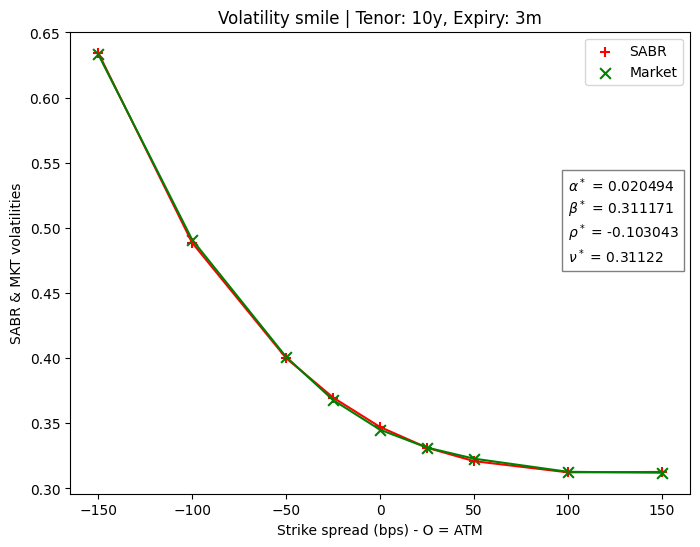

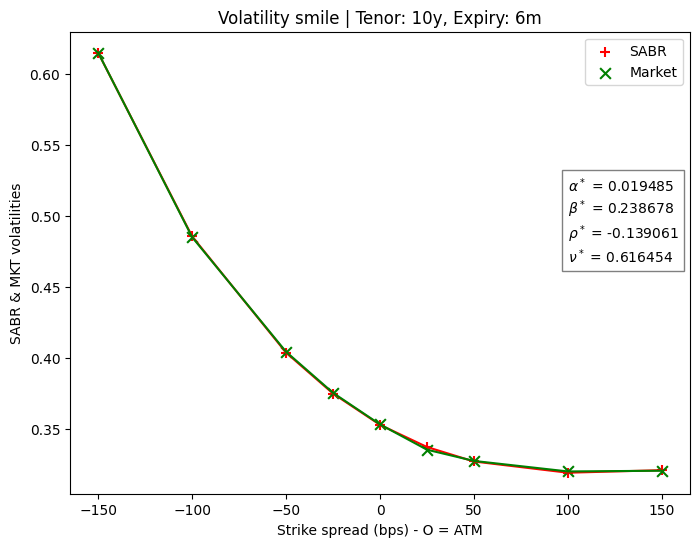

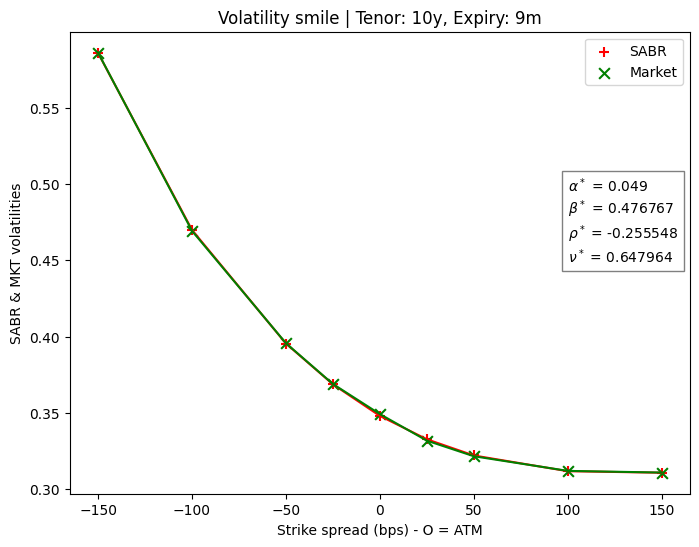

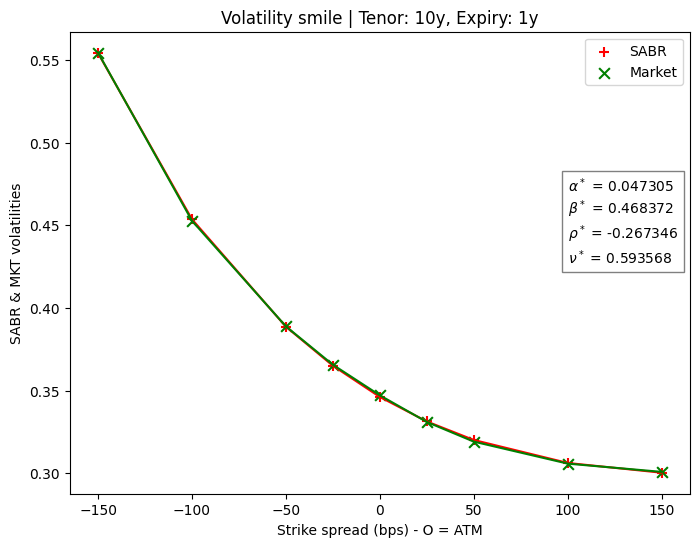

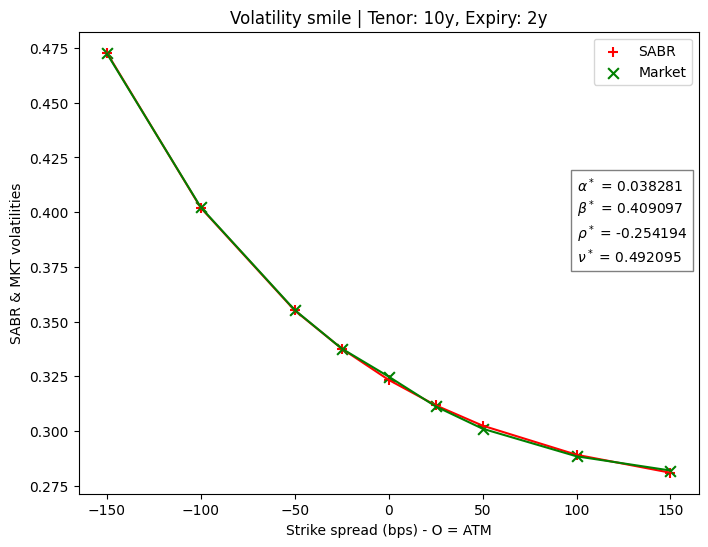

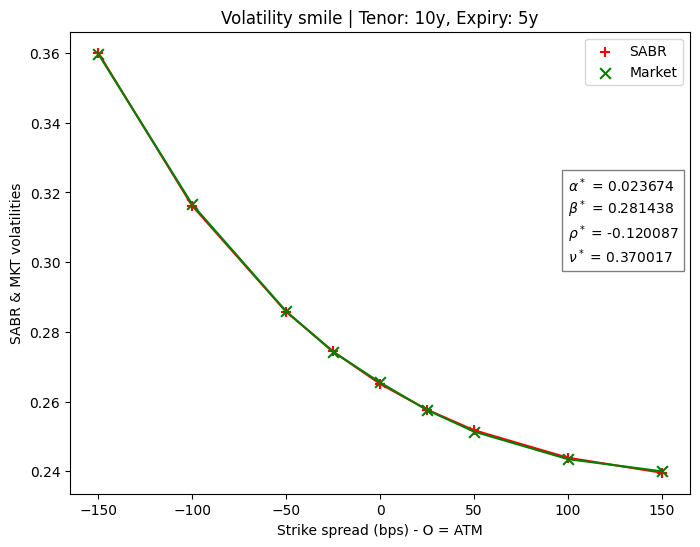

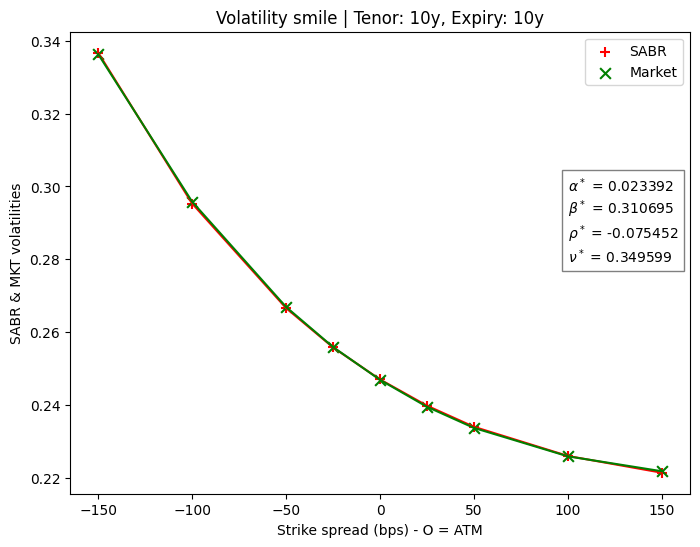

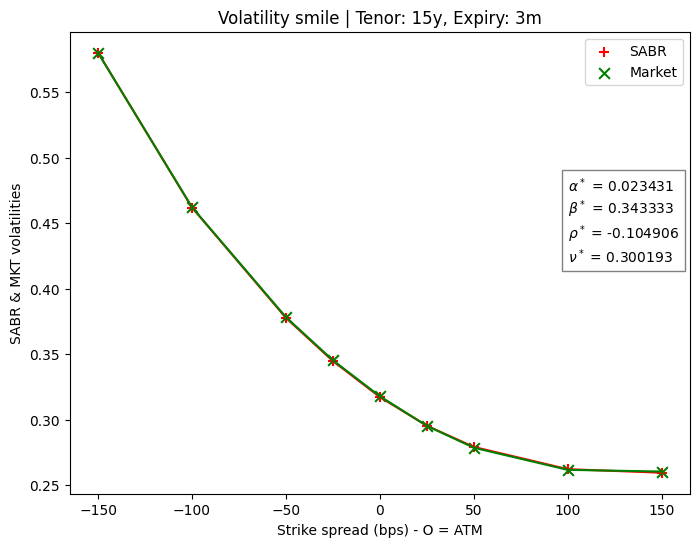

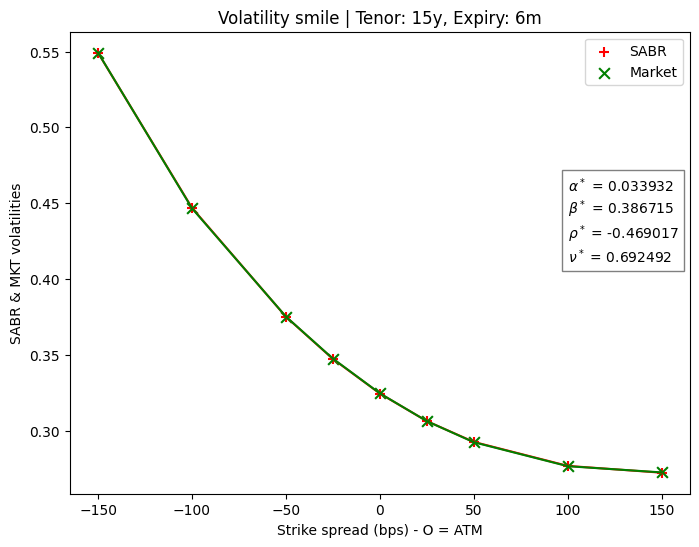

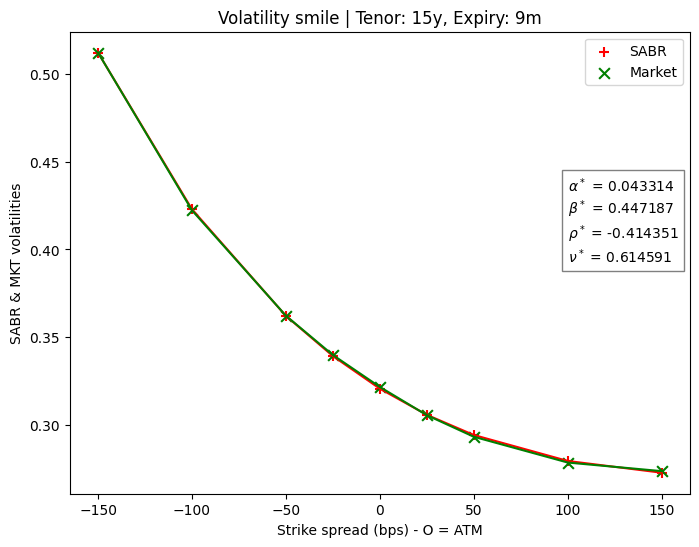

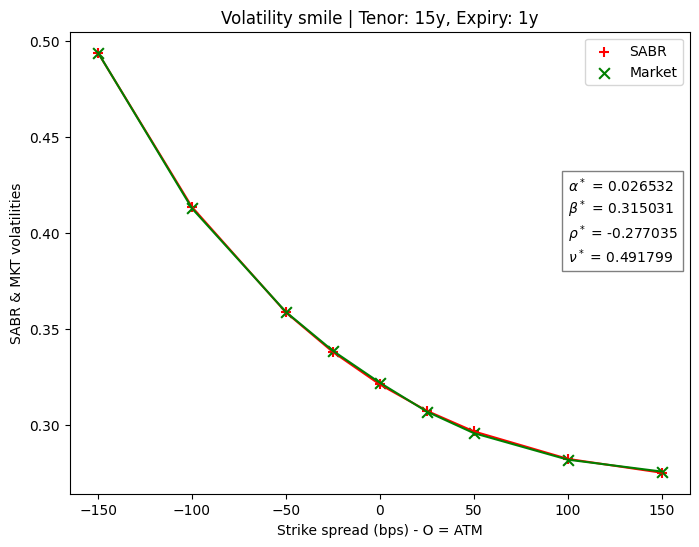

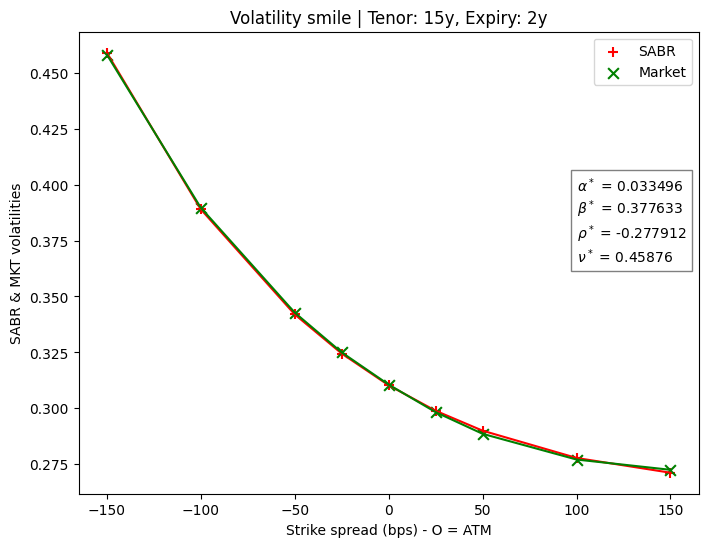

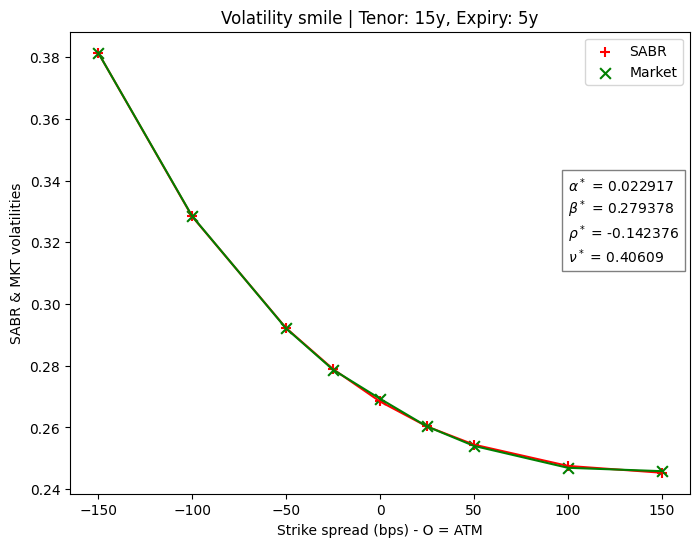

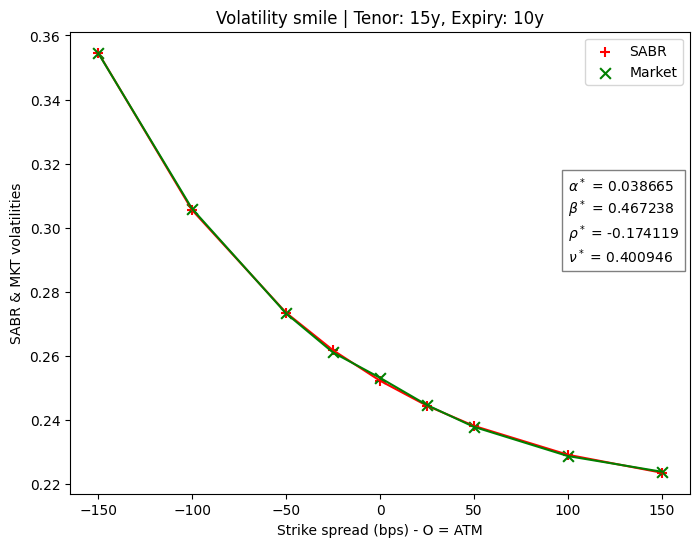

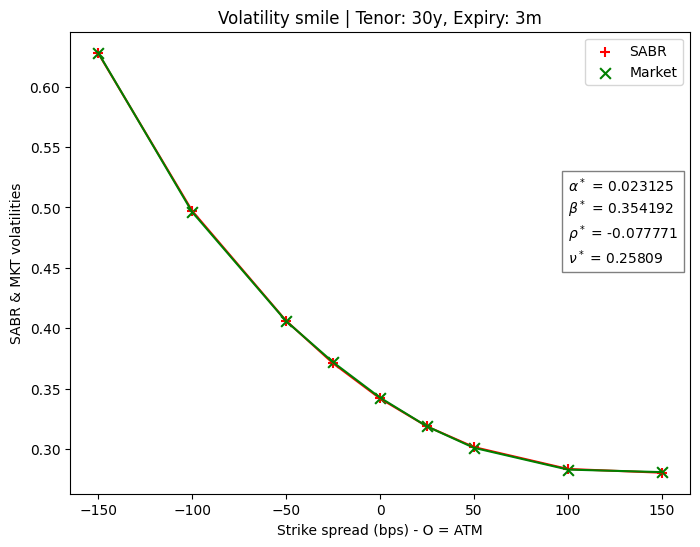

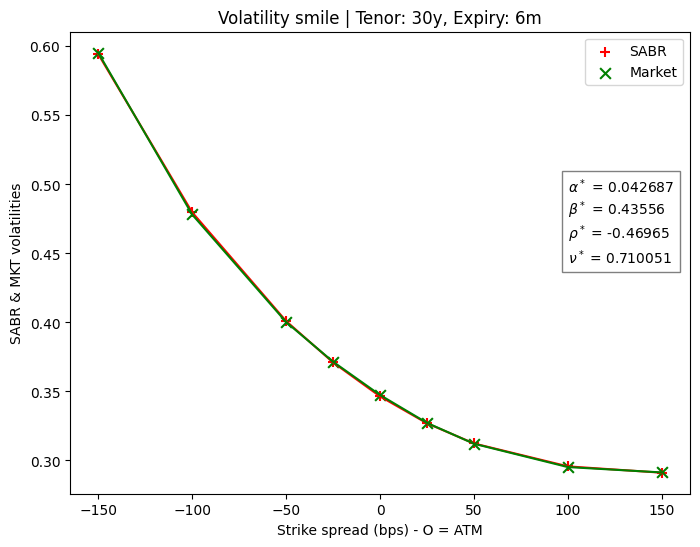

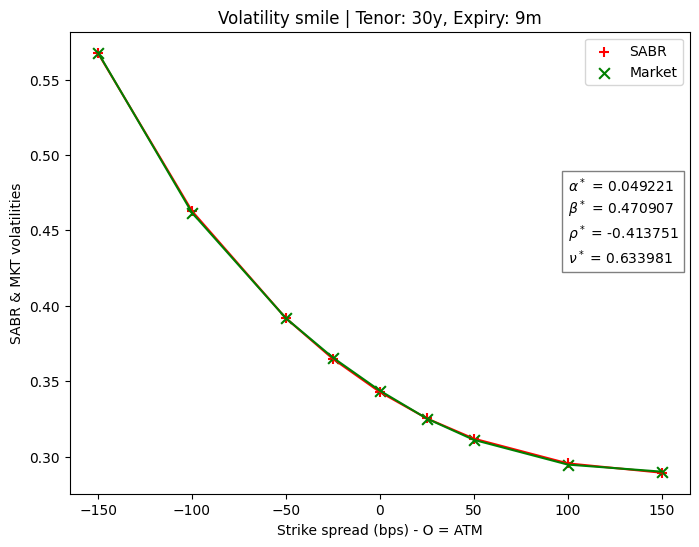

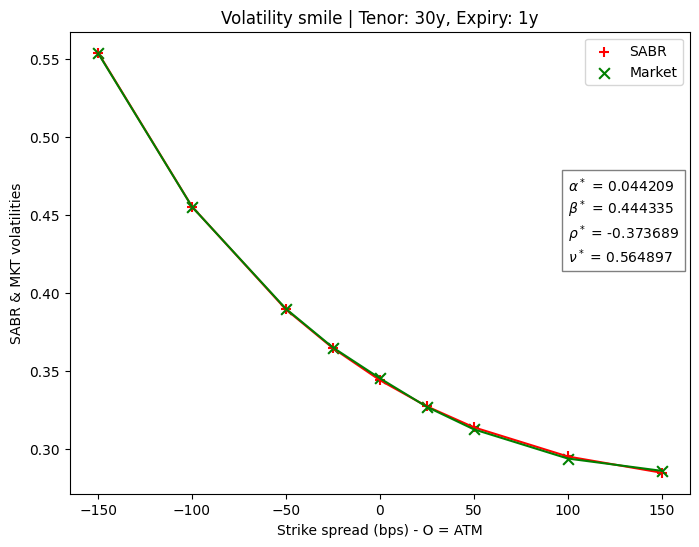

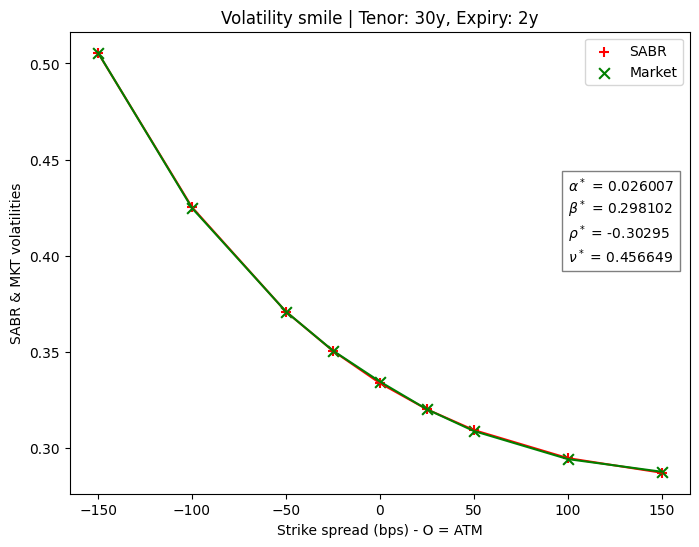

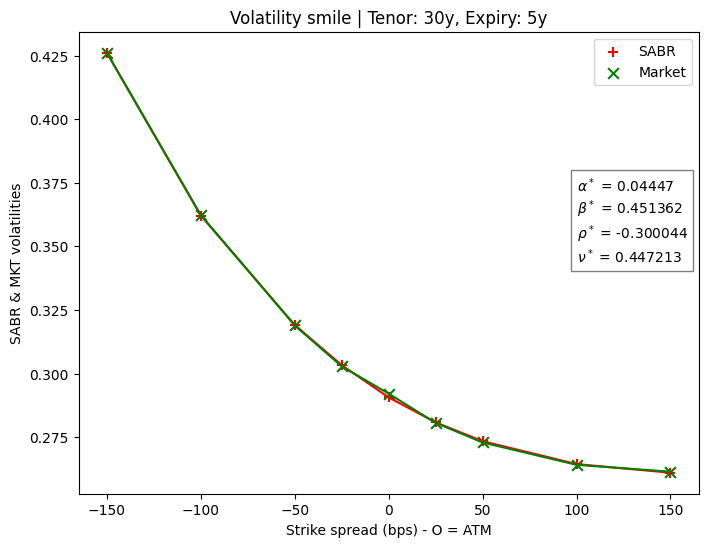

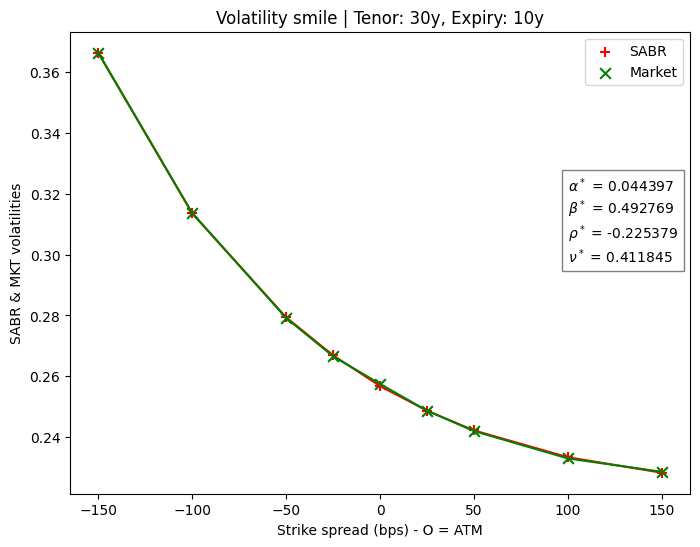

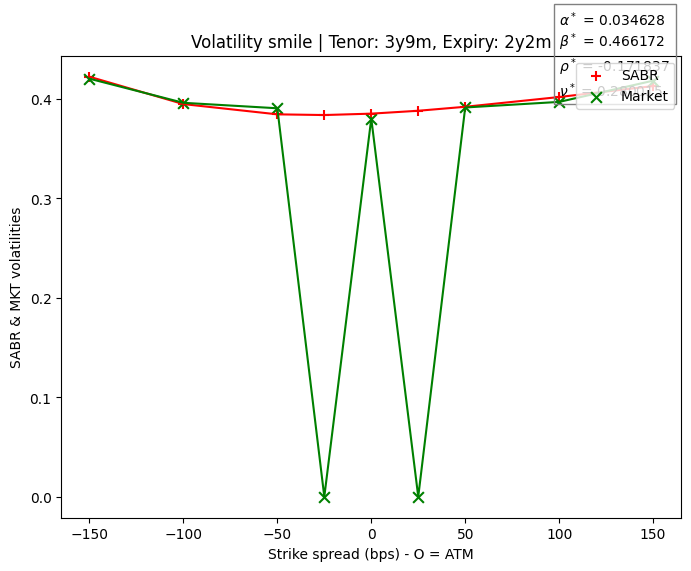

In [79]:
i = 0
for couple in INDEX:
    #print(couple, "\t\t", i)
    
    # Collecting the SABR volatilies for each couple
    VOL_COUPLE_SABR = VOL_SABR.iloc[i,2:11]
    VOL_COUPLE_MKT = VOL_MKT.iloc[i,3:12]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(STRIKES_SPREADS, VOL_COUPLE_SABR, color="red", marker="+", s = 60, label="SABR")
    plt.scatter(STRIKES_SPREADS, VOL_COUPLE_MKT, color="green", marker="x", s = 60, label="Market")
    plt.title(f"Volatility smile | Tenor: {couple[0]}, Expiry: {couple[1]}")
    plt.xlabel("Strike spread (bps) - O = ATM")
    plt.ylabel("SABR & MKT volatilities")
    plt.legend(loc="upper right")
    
    # Interpolation
    f1 = interp1d(x = STRIKES_SPREADS, 
                  y= VOL_COUPLE_SABR,
                  kind = "cubic")
    f2 = interp1d(x = STRIKES_SPREADS, 
                  y= VOL_COUPLE_MKT,
                  kind = "cubic")
    plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
    plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="green")
    
    
    y = (max(VOL_COUPLE_SABR) + min(VOL_COUPLE_SABR))/2
    
    annotation = fr"$\alpha^*$ = {alpha}"
    annotation += "\n"
    annotation += fr"$\beta^*$ = {beta}"
    annotation += "\n"
    annotation += fr"$\rho^*$ = {rho}"
    annotation += "\n"
    annotation += fr"$\nu^*$ = {nu}"
    plt.text(x = 100,
             y = y, 
             s = annotation, 
             bbox = dict(facecolor="none", edgecolor="gray"))
    
    # Collecting the optimized coefficients alpha, beta, rho, nu for each couple
    alpha, beta, rho, nu = parameters.iloc[i, :]
    #print(alpha, beta, rho, nu)
    
    
    # Incrementing
    i += 1

## Study of the impact of the parameters

### Impact of $\alpha$

In [128]:
VOL_ALPHA_1 = pd.read_csv("outvol_alpha_1.csv", sep=";", header=0)
VOL_ALPHA_2 = pd.read_csv("outvol_alpha_2.csv", sep=";", header=0)
VOL_ALPHA_3 = pd.read_csv("outvol_alpha_3.csv", sep=";", header=0)

In [130]:
STRIKES_SPREADS

[-150, -100, -50, -25, 0, 25, 50, 100, 150]

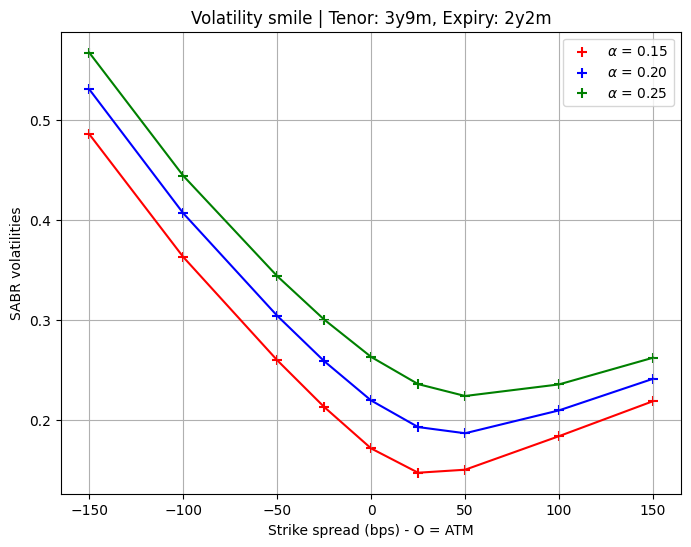

In [142]:
SELECTED_COUPLE = 5

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_1.iloc[SELECTED_COUPLE,2:11], color="red", marker="+", s = 60, label=r"$\alpha$ = 0.15")
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_2.iloc[SELECTED_COUPLE,2:11], color="blue", marker="+", s = 60, label=r"$\alpha$ = 0.20")
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_3.iloc[SELECTED_COUPLE,2:11], color="green", marker="+", s = 60, label=r"$\alpha$ = 0.25")
plt.title(f"Volatility smile | Tenor: {couple[0]}, Expiry: {couple[1]}")
plt.xlabel("Strike spread (bps) - O = ATM")
plt.ylabel("SABR volatilities")
plt.grid()
plt.legend(loc="upper right")


# Interpolation
f1 = interp1d(x = STRIKES_SPREADS, 
              y=  VOL_ALPHA_1.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f2 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_ALPHA_2.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f3 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_ALPHA_3.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
_ = plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
_ = plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="blue")
_ = plt.plot(STRIKES_SPREADS, f3(STRIKES_SPREADS), color="green")

### Impact of $\beta$

In [64]:
VOL_BETA_1 = pd.read_csv("outvol_beta_1.csv", sep=";", header=0)
VOL_BETA_2 = pd.read_csv("outvol_beta_2.csv", sep=";", header=0)
VOL_BETA_3 = pd.read_csv("outvol_beta_3.csv", sep=";", header=0)

In [85]:
STRIKES_SPREADS

[-150, -100, -50, -25, 0, 25, 50, 100, 150]

<AxesSubplot:>

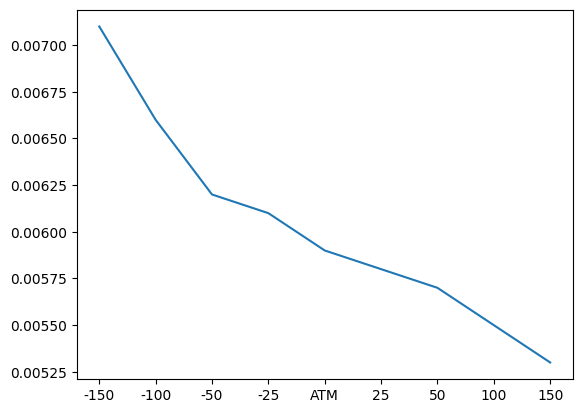

In [133]:
VOL_ALPHA_2.iloc[5,2:11].plot()

In [83]:
VOL_COUPLE_SABR = VOL_SABR.loc[5,2:11]

In [84]:
VOL_COUPLE_SABR

-150    0.4042
-100    0.3536
-50     0.3222
-25     0.3115
ATM     0.3033
25      0.2973
50       0.293
100     0.2881
150     0.2864
Name: 5, dtype: object

### Impact of $\rho$

### Impact of $\nu$

---

**Amal BACHA - Lucas RODRIGUEZ** - November 2022